In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import numpy as np
from glob import glob
import pandas as pd
import sklearn
import os, sys
from matplotlib import pyplot as plt
import warnings

from functools import partial
import shutil

In [ ]:
# copy the csv file folder and train_data.csv to local colab storage
csv_loc = '/content/gdrive/My Drive/Colab Notebooks/idtrees/las_csv_chips_classCodes'
shutil.copytree(csv_loc, './las_csv_chips_classCodes')
shutil.copy('/content/gdrive/My Drive/Colab Notebooks/idtrees/train_data.csv', './train_data.csv')

'./train_data.csv'

In [ ]:
lidar_csvs = glob('./las_csv_chips_classCodes/*.csv')

plotIDs = [os.path.basename(f).split('_')[0] for f in lidar_csvs]
taxonIDs = [pd.read_csv(f).taxonID.values[0] for f in lidar_csvs]


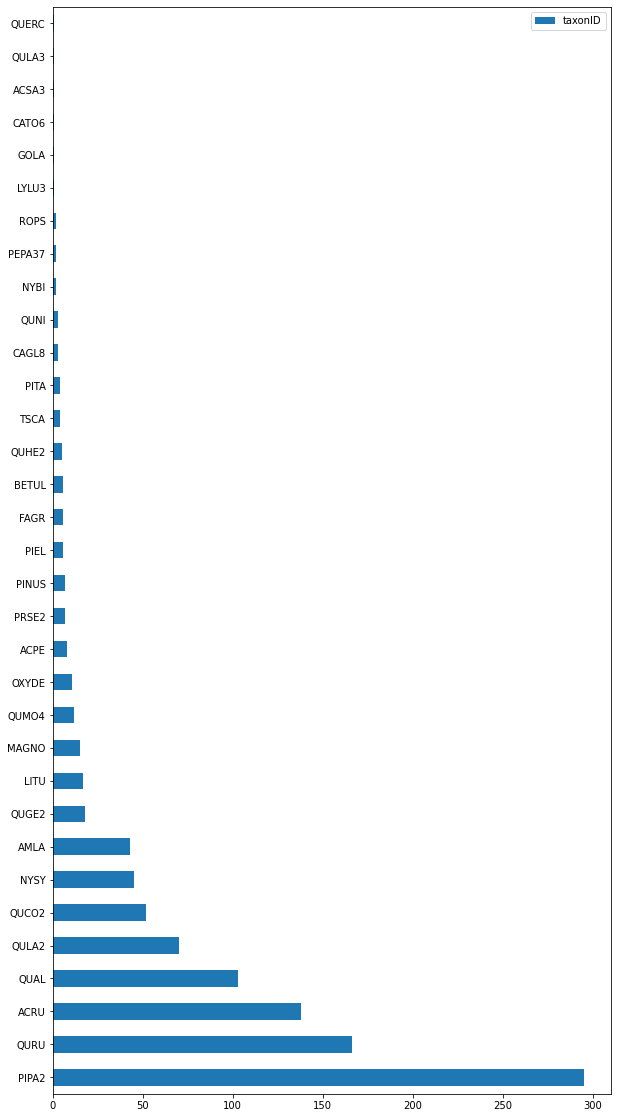

In [ ]:
# plt.hist(taxonIDs, bins=100)
tdf = pd.DataFrame({'taxonID':taxonIDs})
tdfT = tdf[['taxonID']].apply(pd.value_counts)
tdfT.plot(kind='barh', figsize=(10,20))

((40, 1), (1016, 1))

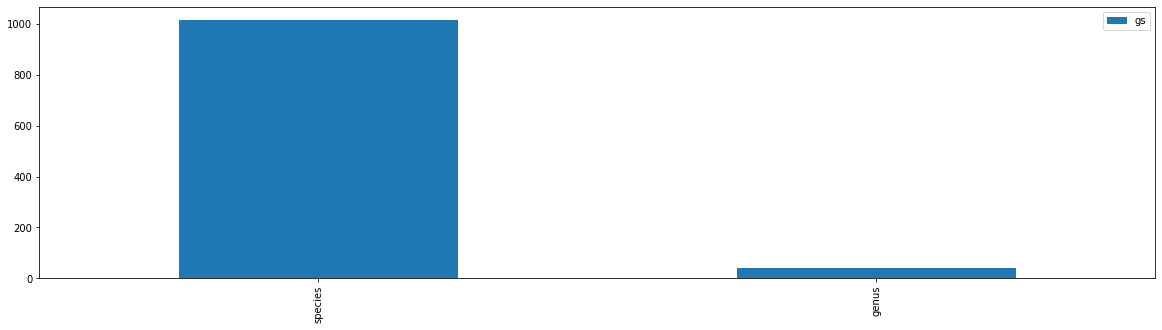

In [ ]:
train_df = pd.read_csv('./train_data.csv')

genus_or_species = [train_df.loc[train_df['indvdID'] == pid].taxonRank.values[0] for pid in plotIDs]
gs_df = pd.DataFrame({'gs': genus_or_species})
gs_df[['gs']].apply(pd.value_counts).plot(kind='bar', figsize=(20,5));

gs_df.loc[gs_df['gs']=='genus'].shape, gs_df.loc[gs_df['gs']=='species'].shape



In [ ]:
# create pseudo waveform and record number of points, using ground or no ground
# a function read the csv and return the non-ground points along with the label
def get_points_with_label(fi, ground=False, labelid='taxonID'):
    df = pd.read_csv(fi)
    
    # record minimum height
    zmin = df['z'].values.min()

    if not ground:
        df = df.loc[df['classCodeLAS'] != 2]

    pts = df[['x', 'y', 'z']]
    label = df['taxonID'].values[0]

    # center point cloud
    pts['x'] = pts['x'] - pts['x'].mean()
    pts['y'] = pts['y'] - pts['y'].mean()
    pts['z'] -= zmin

    return pts.values, label

# a function read the csv and return the non-ground points along with the label
def pseudowaveform(fi, bin_ht=1, ground=False, labelid='taxonID'):
    df = pd.read_csv(fi)
    
    # record minimum height
    zmin = df['z'].values.min()
    zmax = df['z'].values.max()
    zr = zmax - zmin
    label = df['taxonID'].values[0]
    
    if not ground:
        df = df.loc[df['classCodeLAS'] != 2]
        
        # check for zero points
        if df.shape[0]==0:
            warnings.warn(f'file {fi} has zero non-ground points, returning empty array with zero')
            return np.array([[0]]), label, 0
    
    # there is at least 1 point
    pts = df[['x', 'y', 'z']]
    
    # record pseudo waveform
    pswv = np.zeros((1, int(zr/bin_ht)+1))
    for i,z in enumerate(np.arange(zmin, zmax, bin_ht)):
        
        
        _zmin = z
        _zmax = _zmin + bin_ht
        
        zcond = (df['z'] >= _zmin) & (df['z'] < _zmax)
        n = df.loc[zcond].shape[0]
        
        # normalize by total number of points
        pswv[0,i] = n / df.shape[0]
    
    return pswv, label, df.shape[0]

a, b, c = pseudowaveform(lidar_csvs[0])

In [ ]:
# record for all files
pwave_list = list(map(pseudowaveform, lidar_csvs))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: file ./las_csv_chips_classCodes/OSBS03826_points.csv has zero non-ground points, returning empty array with zero
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: file ./las_csv_chips_classCodes/OSBS03397_points.csv has zero non-ground points, returning empty array with zero
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: file ./las_csv_chips_classCodes/OSBS03709_points.csv has zero non-ground points, returning empty array with zero
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: file ./las_csv_chips_classCodes/OSBS03428_points.csv has zero non-ground points, returning empty array with zero
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: file ./las_csv_chips_classCodes/OSBS08092_points.csv has zero non-ground points, returning empty array with zero
/usr/local/lib/python3.6/dist-packages/ipyker

In [ ]:
# use a function to pad them and make them the same length
max_length = np.max([p[0].shape[1] for p in pwave_list])

# now pad
def pad(max_len, arr):
    
    if arr.shape[1] < max_len:
        
        newarr = np.zeros((1,max_len))
        newarr[0,:arr.shape[1]] = arr
        
        return newarr
    else:
        return arr
    
        
def create_padded_df(res_list):
    
    # get max length for padding
    max_length = np.max([p[0].shape[1] for p in res_list])
    
    # record number of points
    num_pts = [p[-1] for p in res_list]
    taxons = [p[1] for p in res_list]
    
    # map the padding function
    waves = list(map(partial(pad, max_length), [p[0] for p in res_list]))
    
    # make some columns for the waveforms
    cols = [f'bin_{b+1}' for b in range(max_length)]
    
    # create numpy array for the waveforms
    waves_arr = np.array(waves)
    waves_arr = waves_arr.squeeze()
    
    # append number of points and taxons to the array. add columns too
    cols += ['numpts', 'taxonID']
    numpts_arr = np.array(num_pts)
    numpts_arr = numpts_arr[...,np.newaxis]
    taxon_arr = np.array(taxons)
    taxon_arr = taxon_arr[...,np.newaxis]
    
    print(waves_arr.shape, numpts_arr.shape, taxon_arr.shape)
    waves_arr = np.hstack((waves_arr, numpts_arr, taxon_arr))
    
    return pd.DataFrame(waves_arr, columns=cols)

pdf = create_padded_df(pwave_list)

(1056, 39) (1056, 1) (1056, 1)


In [ ]:
pdf2 = pdf.copy()
pdf2['indvdID'] = [os.path.basename(f).split('_')[0] for f in lidar_csvs]
pdf2.head()
pdf2.to_csv('idtrees_pwave_indvdID.csv')

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [ ]:
# iterate over min pts for random forest 
scores=[]
minpts=[]
for mp in range(1, 100):
    
    X = pdf.iloc[:,:-2]
    y = pdf.iloc[:,-1:]
    
    ## here, remove rows that have less than minpts
    # minpts=1
    X = X.loc[pdf['numpts'].astype('float')>=mp]
    y = y.loc[pdf['numpts'].astype('float')>=mp]

    y = y.values.ravel()
    rs=42
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=rs)
    
    RFC = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=rs)
    RFC.fit(X_train, y_train)
    
    
    minpts.append(mp)
    scores.append(RFC.score(X_test, y_test))


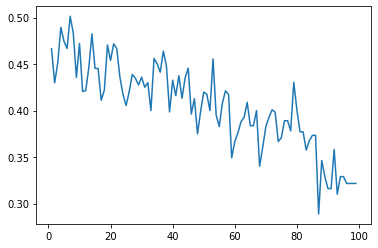

In [ ]:
plt.plot(minpts, scores)

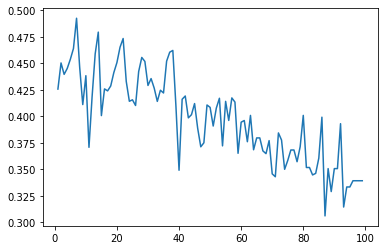

In [ ]:
# iterate over min pts for extra trees
scores=[]
minpts=[]
for mp in range(1, 100):
    
    X = pdf.iloc[:,:-2]
    y = pdf.iloc[:,-1:]
    
    ## here, remove rows that have less than minpts
    # minpts=1
    X = X.loc[pdf['numpts'].astype('float')>=mp]
    y = y.loc[pdf['numpts'].astype('float')>=mp]

    y = y.values.ravel()
    rs=42
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=rs)
    
    ETC = ExtraTreesClassifier(n_estimators=100, max_depth=10, random_state=rs)
    ETC.fit(X_train, y_train)
    
    
    minpts.append(mp)
    scores.append(ETC.score(X_test, y_test))
    
plt.plot(minpts, scores)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

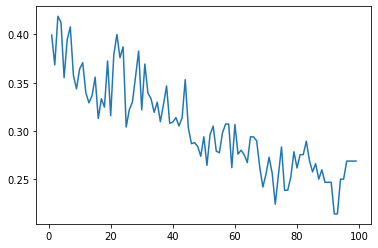

In [ ]:
# iterate over min pts for MLP
scores=[]
minpts=[]
for mp in range(1, 100):
    
    X = pdf.iloc[:,:-2]
    y = pdf.iloc[:,-1:]
    
    ## here, remove rows that have less than minpts
    # minpts=1
    X = X.loc[pdf['numpts'].astype('float')>=mp]
    y = y.loc[pdf['numpts'].astype('float')>=mp]

    y = y.values.ravel()
    rs=42
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=rs)
    
    MLPC = MLPClassifier(hidden_layer_sizes=(100, ), 
                        activation='relu', 
                        solver='adam', 
                        alpha=0.0001, 
                        batch_size='auto', 
                        learning_rate='constant', 
                        learning_rate_init=0.01, 
                        power_t=0.5, 
                        max_iter=1000, 
                        shuffle=True, 
                        random_state=rs)
    MLPC.fit(X_train, y_train)
    
    
    minpts.append(mp)
    scores.append(MLPC.score(X_test, y_test))
    
plt.plot(minpts, scores)

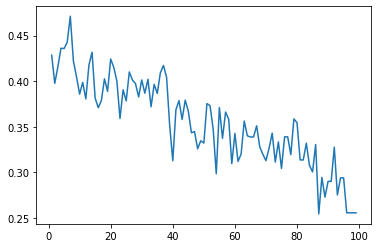

In [ ]:
# iterate over min pts for SVM
scores=[]
minpts=[]
for mp in range(1, 100):
    
    X = pdf.iloc[:,:-2]
    y = pdf.iloc[:,-1:]
    
    ## here, remove rows that have less than minpts
    # minpts=1
    X = X.loc[pdf['numpts'].astype('float')>=mp]
    y = y.loc[pdf['numpts'].astype('float')>=mp]

    y = y.values.ravel()
    rs=42
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=rs)
    
    SVC_classifier = SVC(random_state=rs)
    SVC_classifier.fit(X_train, y_train)
    
    
    minpts.append(mp)
    scores.append(SVC_classifier.score(X_test, y_test))
    
plt.plot(minpts, scores)